# Introduction #

We'll cover the concept of clustering through several popular models. But first, it should be known that there are two major forms of clustering: 

<ol>
    <li> Hard clustering: Something belongs to a cluster, or not - (mixture not allowed)
    <li> Soft clustering: Something belongs to a cluster according to some probability (mixture allowed)

## Models Covered ##

1. KMeans
2. Gaussian Mixture (GM)
3. Self Organizing Maps
        
### and including some helpful data preparation techniques ###

1. Principal Component Analysis

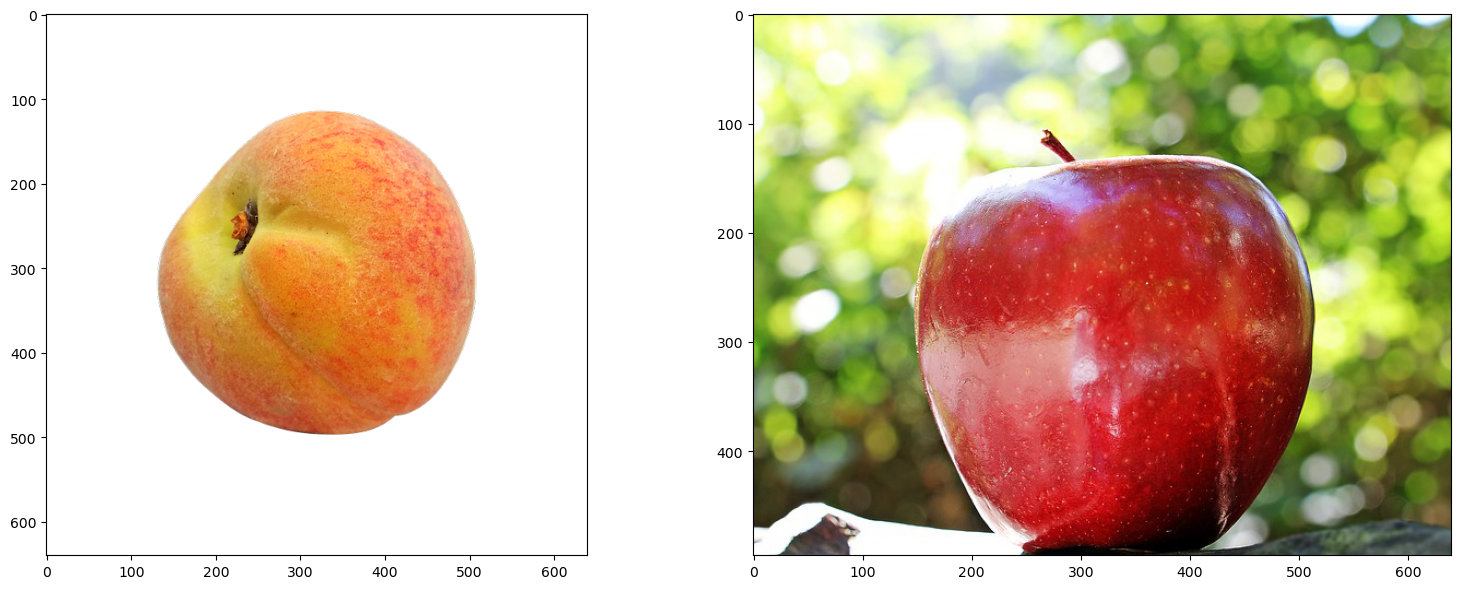

In [1]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
img1 = plt.imread('jupyter_example/peach.png')
img2 = plt.imread('jupyter_example/apple.jpg')

f, ax = plt.subplots(1, 2, figsize=(16,6))

ax[0].imshow(img1)
ax[1].imshow(img2)

plt.tight_layout()
plt.show()

Say we have two clustering models have been trained to separate fruit, one model uses hard and the other soft. If both were used to predict what cluster the apple image belongs to, they might report something like:

**Hard Model:** Predict(Apple) ---> Belongs to Apple Cluster

**Soft Model:** Predict(Apple) ---> 90 % apple, 10% peach

But before we cover the clustering models, let's discuss some data preparation methods.

# Data Preparation Methods #

A huge variety of data preparation methods exist and this is not the place to cover all of them... But let's classify them into a handful of categories:


1. **Feature / Data point removal**:
    Pretty obvious, just tossing features or segments of data points that (you're confident!!) are not relevant to your problem


2. **Feature / Data point reduction**:
    1. For features, this would be collapsing them into a lesser number of features e.g. if you have data in 2d <x,y> space but you're only concerned with distance from a point D, you could make a new feature dist = $\sqrt{(x^2+y^2)} - D$ and remove the features x and y.
    2. For data points, this could be lowering the resolution that points are measured by e.g. for time data, you could separate everything into 60 sec intervals and average them down to one minute (the number of data points has decreased, but the number of features is the same).
    
    
3. **Feature Scaling**:
    Modifying the values of your features according to some scale, usually dependent upon how that data is distributed. The two most popular ones are ...
    1. *standardization*: Transforming each feature such that its mean is 0 and standard deviation is 1. Different features will probably have different min and max values (which *sometimes* affects model performance, but not too much).
    2. *min-max-scaling*: The new min / max of your data is 0 and 1 for all of your features (sometimes, this is called *normalization*)
    
    It almost goes with saying, but both of these are **very** susceptible to outliers.
    
As a quick example of feature standardization vs min-max, let's generate some data and look at some violin plots:

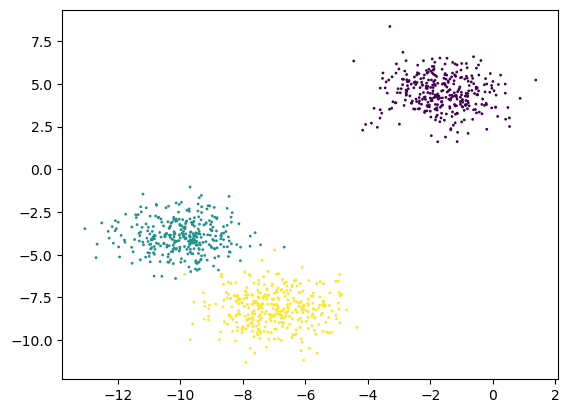

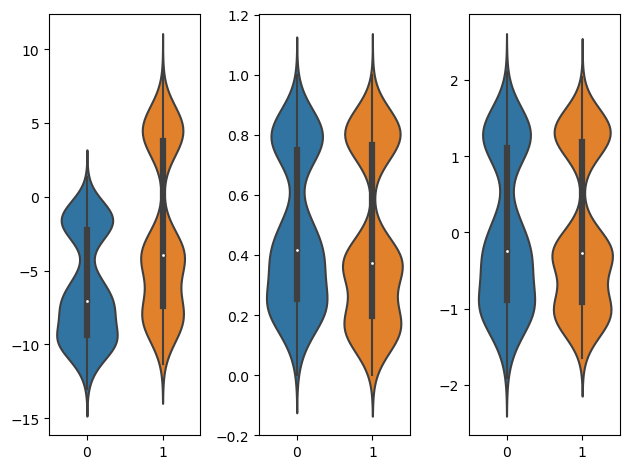

In [2]:
from sklearn import datasets
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import numpy as np

rng_seed = 1


def prep_data(data, fit=None):
    # if no fit, then do nothing
    if fit is None:
        return data
    # otherwise, standardize or normalize
    scaler = None
    if fit == 'standardize':
        scaler = StandardScaler()
    if fit == 'normalize':
        scaler = MinMaxScaler()
    return scaler.fit_transform(data)


dat, src = datasets.make_blobs(n_samples=1000,
                               n_features=2,
                               random_state=rng_seed)


fig, ax = plt.subplots(1,1)
ax.scatter(dat[:,0], dat[:,1], s=1, c=src)


fig, axes = plt.subplots(1,3)
sns.violinplot(dat, ax=axes[0])
sns.violinplot(prep_data(dat, fit='normalize'),
               ax=axes[1])
sns.violinplot(prep_data(dat, fit='standardize'),
               ax=axes[2])
fig.tight_layout()


In the (seaborn-implemented) violin plots, the white dot is the median, the bounds of the thicker vertical rectangles are the interquartile points (25 and 75 percentiles), and the thinner rectangle bounds are the ends of the +/- 1.5 * IQR (where IQR = 75 - 25 percentiles). And the kernel density estimation used to compute the smoothed density functions sometimes goes a little beyond data bounds, so the normalization plot has a head and tail slightly beyond 0 and 1.

Now we'll include some outliers (just splattering two small gaussians centered at (x,y) = [500,0] and [0,500]) to show how easily the underlying distributions can get squashed:

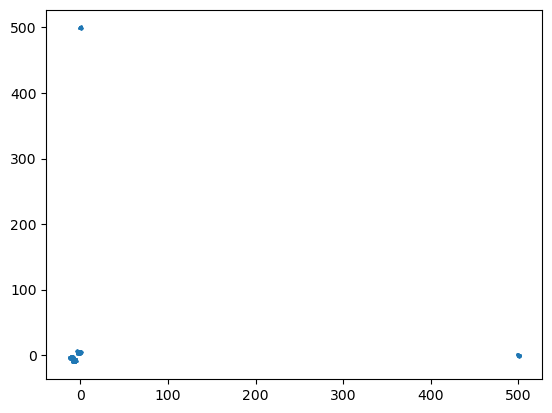

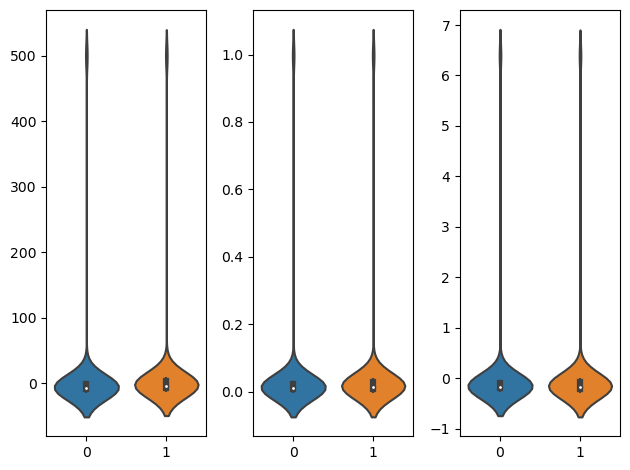

In [3]:
xn, out_src = datasets.make_blobs(n_samples=50,
                                  n_features=2,
                                  centers=[(500,0), (0,500)],
                                  random_state=rng_seed)

# combine original data and new outliers
dat = np.vstack( [xn, dat] )
src = np.hstack( [src, out_src+max(src)+1] )


fig, ax = plt.subplots(1,1)
ax.scatter( dat[:,0], dat[:,1], s=1)


fig, axes = plt.subplots(1,3)
sns.violinplot(dat, ax=axes[0])
sns.violinplot(prep_data(dat, fit='normalize'),
               ax=axes[1])
sns.violinplot(prep_data(dat, fit='standardize'),
               ax=axes[2])
fig.tight_layout()

In general, it is **strongly** recommended to either standardize or normalize your data before training a model. It may not always be the case for the datasets in this notebook due to their small scale, but differences in ranges will have enormous impacts on the convergence of your clustering models.


# Model: KMeans #

KMeans is a hard clustering model and requires specifying the number of clusters you want to find in advance.

Simply put,...
1. a point in input-space will be created for each initial cluster.
2. Data points will be said to belong to whichever of these cluster centers they're closest to.
3. The cluster centers are updated by computing an average over each feature of the data inside the cluster.

Let's look at a simple example involving two distant gaussians

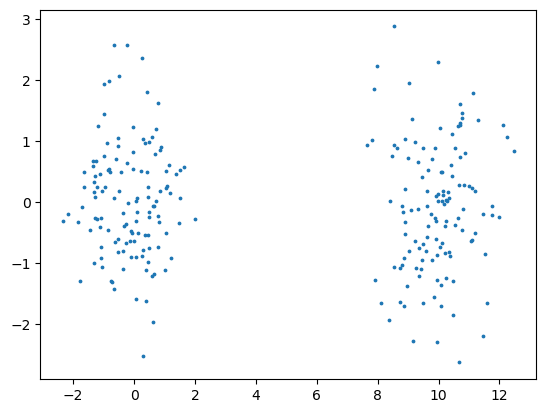

In [4]:
two_gauss, src = datasets.make_blobs(n_samples=250,
                                     n_features=2,
                                     centers=[(0,0), (10,0)])

fig, ax = plt.subplots(1,1)
ax.scatter( *two_gauss.T, s=3 )

Now we'll train a KMeans model to find 2 clusters within this dataset.

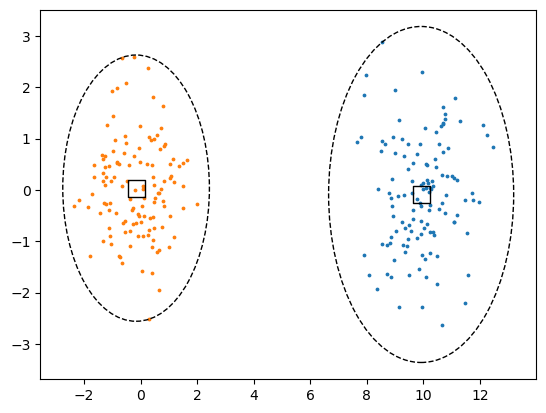

In [5]:
from sklearn.cluster import KMeans


def plot_kmeans_preds(kmeans_inst, data, ax=None, show_circle=None):
    """
    Using a scikit-learn trained kmeans instance, plot the data with different
    colors according to KMeans prediction.
    
    data: 2d numpy array with model transform already applied
    
    ax: matplotlib axis
        plots data onto given matplotlib axis
        
    show_circle: bool
        plots circle with radius being farthest point from cluster centers onto axis
    """
    
    if ax is None: fig, ax = plt.subplots(1,1)
    if show_circle is None: show_circle = False
    centers = kmeans_inst.cluster_centers_
    circle_kwargs = { 'facecolor':'None',
                      'edgecolor':'black',
                      'linestyle':'dashed' }
    
    # get predictions 
    preds = kmeans_inst.predict(data)
    
    # For each cluster, plot its data ...
    for i in range(centers.shape[0]):
        mask = preds == i
        max_dist = np.max( np.linalg.norm(data[mask] - centers[i], axis=1) )
        ax.scatter( data[mask,0], data[mask,1], s=3)
        ax.scatter( *centers[i], marker='s', s=150, facecolor='none', edgecolor='black')
        
        # ... and make circle around center (if specified)
        if show_circle:
            circle = plt.Circle( centers[i], max_dist, **circle_kwargs )
            ax.add_patch(circle)

            
            

kmeans = KMeans(n_clusters=2,
                n_init=10,
                random_state=rng_seed)

kmeans.fit(two_gauss)

plot_kmeans_preds( kmeans, two_gauss, show_circle=True )


Works very well! But that's only because the clusters could be easily separated with circles. When data overlaps, or when data is not approximately spherically distributed, KMeans fails.

In a adjacent folder, I made a function that easily constructs N-dim gaussian with arbitrary covariance matrices (so it could be positively-correlated, negatively-correlated, isotropic, or anything in between). Importing that function, we'll overlap a positively-correlated gaussian with a negatively-correlated one and make it so that they have the same mean vectors.

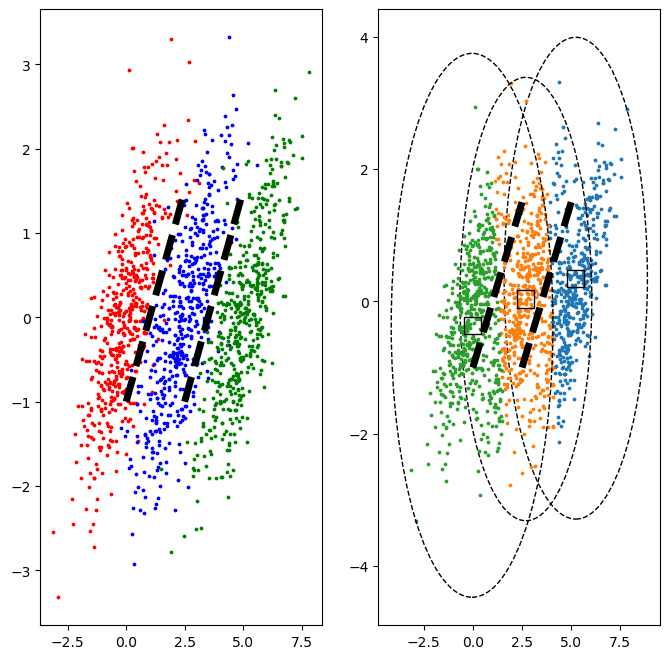

In [6]:
from newb_som_driver import make_mv_gauss


scale = 1.0
corr = 0.75
covmats = [ np.array([[1,corr],[corr,1]]) * scale,
            np.array([[1,-corr],[-corr,1]]) * scale ]
covmats = [ np.array([[1,corr],[corr,1]]) * scale for i in range(3) ]
    
    
## make gaussian data
g_dat, g_src = make_mv_gauss(num_gauss    = 3,
                             n_per_gauss  = 500,
                             means        = [(0,0),(2.5,0),(5,0)],
                             covmats      = covmats,
                             seed         = rng_seed,
                             single_array = True)

fig, axes = plt.subplots(1,2,figsize=(8,8))
axes[0].scatter( *g_dat[g_src==0].T, s=3, c='red' )
axes[0].scatter( *g_dat[g_src==1].T, s=3, c='blue' )
axes[0].scatter( *g_dat[g_src==2].T, s=3, c='green' )
axes[0].plot( (0,2.5), (-1,1.5), linestyle='dashed', color='black', lw=5 )
axes[0].plot( (2.5,5), (-1,1.5), linestyle='dashed', color='black', lw=5 )


kmeans = KMeans(n_clusters=3,
                n_init=10,
                random_state=rng_seed)
preds = kmeans.fit(g_dat)
plot_kmeans_preds(kmeans, g_dat, ax=axes[1], show_circle=True)
axes[1].plot( (0,2.5), (-1,1.5), linestyle='dashed', color='black', lw=5 )
axes[1].plot( (2.5,5), (-1,1.5), linestyle='dashed', color='black', lw=5 )

And it's terribly wrong! This is because the data can't be decomposed into two non-overlapping circles.

Sometimes people will try and get around this by resolving **a lot** of smaller circular clusters, but this can be exceedingly computationally expensive on larger datasets (especially as the dimensionality gets higher). But this can still be helpful for certain problems and can be used as part of a multi-stage clustering model in which you'd give the KMeans results to another, more robust clustering model.

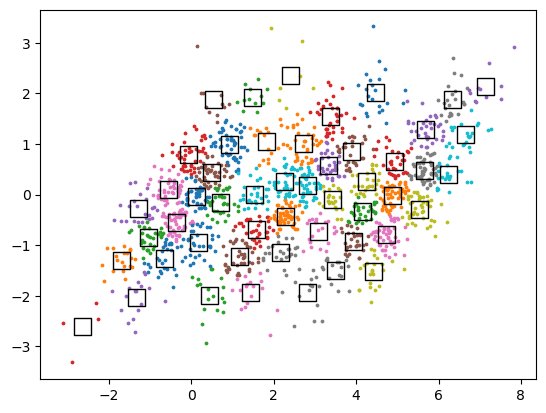

In [7]:
kmeans = KMeans(n_clusters=50,
                n_init=10,
                random_state=rng_seed)
preds = kmeans.fit(g_dat)
plot_kmeans_preds(kmeans, g_dat)

# Gaussian Mixture Model #

KMeans ultimately can only resolve clusters approximately separated into N-dim spheres. One step beyond this is to model all the clusters as Guassians (for which spherical distributions are a strict subset - the isotropic Gaussian - the same variance along all directions and no covariances) so that their additive combination is a Gaussian Mixture (GM).

We've essentially scaled up our clustering geometry from circles to ellipses.

The model assumes that the probability distribution function of the data is composed of gaussians, each of which has a mean vector $\mu$, a covariance matrix $\Sigma$, and a weight $\pi$. The total pdf is

$$ f(x|\{\mu\}, \{\Sigma\}, \{\pi\}) = 
    \pi_1 G(x|\mu_1, \Sigma_1) + \pi_2 G(x|\mu_2, \Sigma_2) + ... + \pi_k G(x|\mu_k, \Sigma_k) $$
    
where $\{\mu\}$ represents all means vectors $\mu_1$, $\mu_2$, ..., $\mu_k$ and similarly for $\{\Sigma\}$ and $\{\pi\}$.

The way these are solved involves either MCMC or Bayesian inferencing, but the exact details are beyond this notebook. Just know that methods exist to get approximations for all these parameters. 

Let's model the above gaussians using GM.

In [8]:
from matplotlib import patches
from sklearn.mixture import GaussianMixture


def plot_gm_preds(gm_inst, dat):
    
    preds = gm_inst.predict_proba(dat)
    num_comps = preds.shape[1]
    
    nrows = int(np.ceil( np.sqrt(num_comps+1) ))
    ncols = nrows
    fig, axes = plt.subplots(nrows, ncols, figsize=(8,8))
    last_ind = num_comps
    axes = axes.reshape(nrows * ncols)
    
    for i in range(last_ind):
        ax = axes[i]
        scat = ax.scatter( *dat.T, s=1, cmap='spring', c=preds[:,i] )
        ax.set_title('C' + str(i+1) + ' Prob')
        fig.colorbar(scat, ax=ax)
        make_ellipses(gm_inst, ax)
    
    scat = axes[last_ind].scatter( *dat.T, s=1, cmap='cool', c=np.max(preds,axis=1) )
    axes[last_ind].set_title('Max Prob')
    fig.colorbar(scat, ax=axes[last_ind])
    make_ellipses(gm_inst, axes[last_ind])
    
    for i in range(last_ind+1, axes.shape[0]):
        axes[i].set_axis_off()
    
    fig.subplots_adjust(hspace=0.5, wspace=0.5)
    plt.show()
    
    

    
def make_ellipses(gmm, ax):
    for n in range(len(gmm.means_)):
        if gmm.covariance_type == "full":
            covariances = gmm.covariances_[n][:2, :2]
        elif gmm.covariance_type == "tied":
            covariances = gmm.covariances_[:2, :2]
        elif gmm.covariance_type == "diag":
            covariances = np.diag(gmm.covariances_[n][:2])
        elif gmm.covariance_type == "spherical":
            covariances = np.eye(gmm.means_.shape[1]) * gmm.covariances_[n]
        v, w = np.linalg.eigh(covariances)
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
        ell = patches.Ellipse(
            gmm.means_[n, :2], v[0], v[1], angle=180 + angle#, color=color
        )
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.3)
        ax.add_artist(ell)

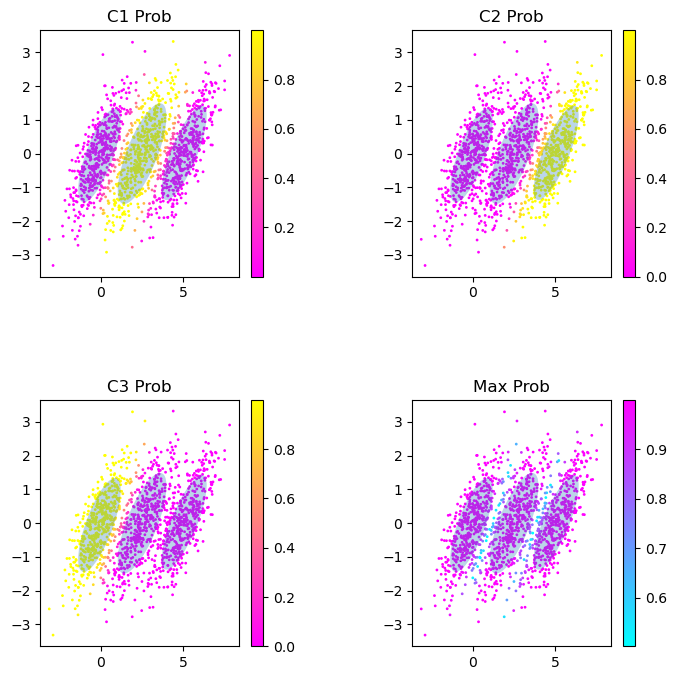

In [9]:
gm = GaussianMixture(n_components=3,
                     random_state=rng_seed,
                     covariance_type='full',
                     n_init=10).fit(g_dat)        
        
plot_gm_preds(gm, g_dat)

Now let's apply GM to something that is NOT gaussian distributed (and is a very good minimalist and robust clustering problem): Resolving concentric circles!

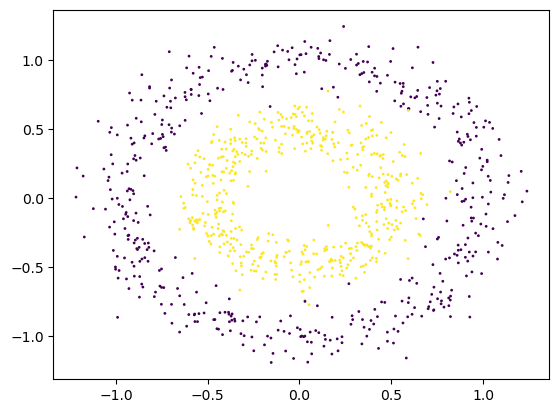

In [10]:
c_dat, c_src = datasets.make_circles(n_samples=1000,
                                     random_state=rng_seed,
                                     noise=0.1,
                                     factor=0.5)

plt.scatter( *c_dat.T, s=1, c=c_src )

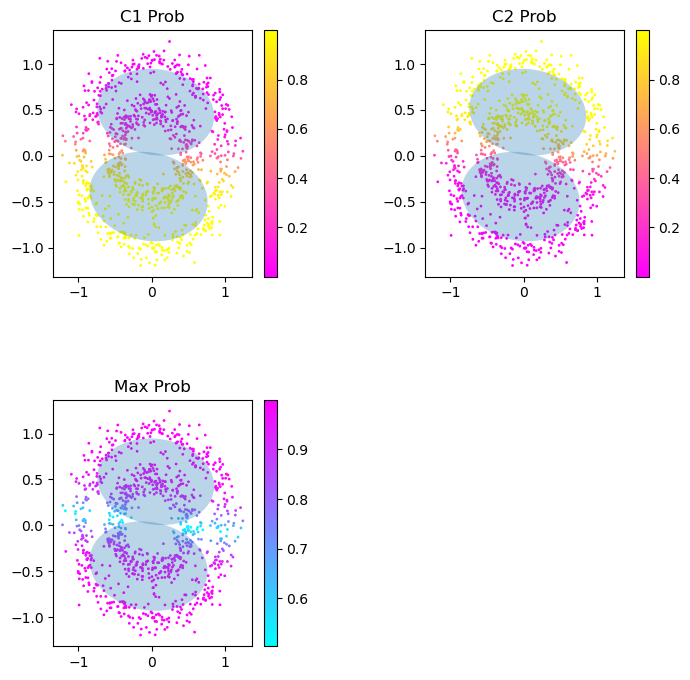

In [11]:
gm = GaussianMixture(n_components=2,
                     random_state=rng_seed,
                     covariance_type='full',
                     n_init=10).fit(c_dat)
plot_gm_preds(gm, c_dat)

As expected, it fails. How about with many gaussians?

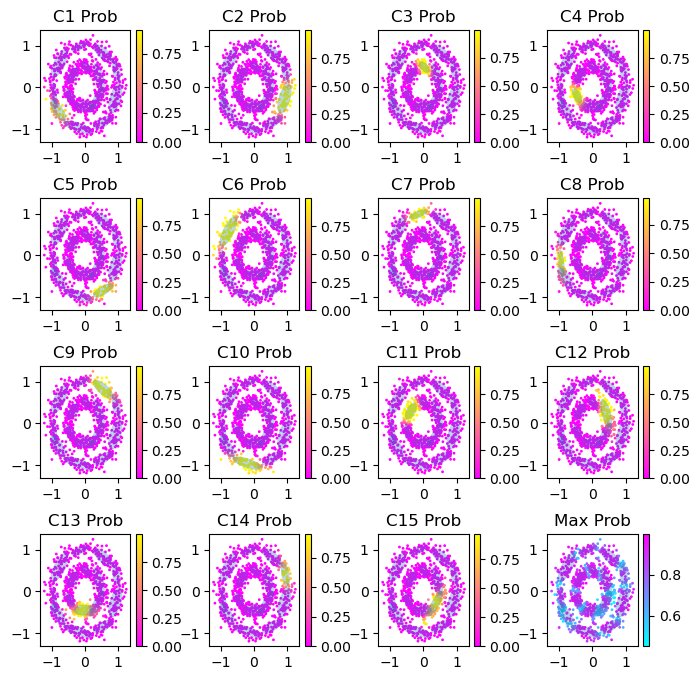

In [12]:
gm_many = GaussianMixture(n_components=15,
                          random_state=rng_seed,
                          covariance_type='full',
                          n_init=10).fit(c_dat)
plot_gm_preds(gm_many, c_dat)

Separating these two circles is a nonlinear problem (literally, the region separating them is a circle - not a line!) So clustering models that create linearly separated clusters can't solve it in the usual way. There are the *cheat* ways, like usings many more clusters than is in the data ...

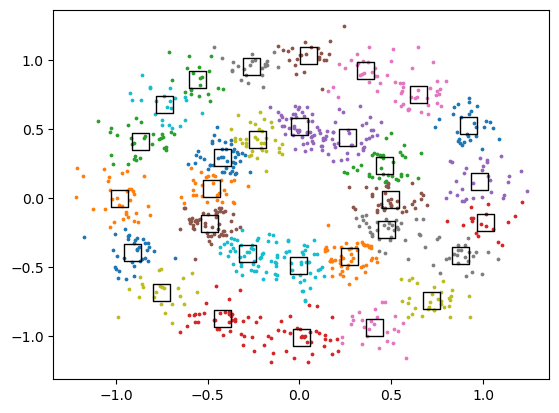

In [13]:
kmeans = KMeans(n_clusters=30,
                n_init=10,
                random_state=rng_seed)
preds = kmeans.fit(c_dat)
plot_kmeans_preds(kmeans, c_dat)

... but this *not scalable* to larger datasets for many such algorithms. Usually due to one of the following:

1. Run-time (GM with k clusters and unique covariance matrices scales like $O(k^4)$) 
2. Arrays-sizes (not enough RAM / some clustering models do **not** support batch learning - needs everything at once)
3. Curse of Dimensionality (high-dimensional points all start to have very similar distances measured relative to anywhere)

    In a 20-dim uniformly-distributed space, >99% of the data will be in the hyper-cube margins - and nowhere near the origin!

Wat do?

# Self-Organizing Maps (SOM) #

## SOM: Motivation ##

### Competition *then* Cooperation ###

Even for simple models, specifying a lot of clusters on non-linear data still returns nice and segmented results. This is due to the competitive nature in which the clusters compete for space. We'll extend this to include a *cooperative* element: As a cluster moves to occupy a space, we'll make it so that it can pull nearby clusters with it. Over iterations, the strength of the 'neighbor-pulling' will have less and less effect.

### Subspace Projection ###

If we had infinite RAM, we *could* compute KMeans on a high dimensional dataset with a large number of clusters. Even though it might resolve nicely, we would still struggle to visualize it (KMeans result on a 20-dim dataset would still produce 20-dim cluster centers). So we'll project into a space that is highly visible to us, a 2d space.

## SOM: Structure ##

The general trend of machine learning, supervised or not, is to use neural networks with large / high-dimensional datasets as they can approximate *any* function. One useful unsupervised neural network is a self-organizing map

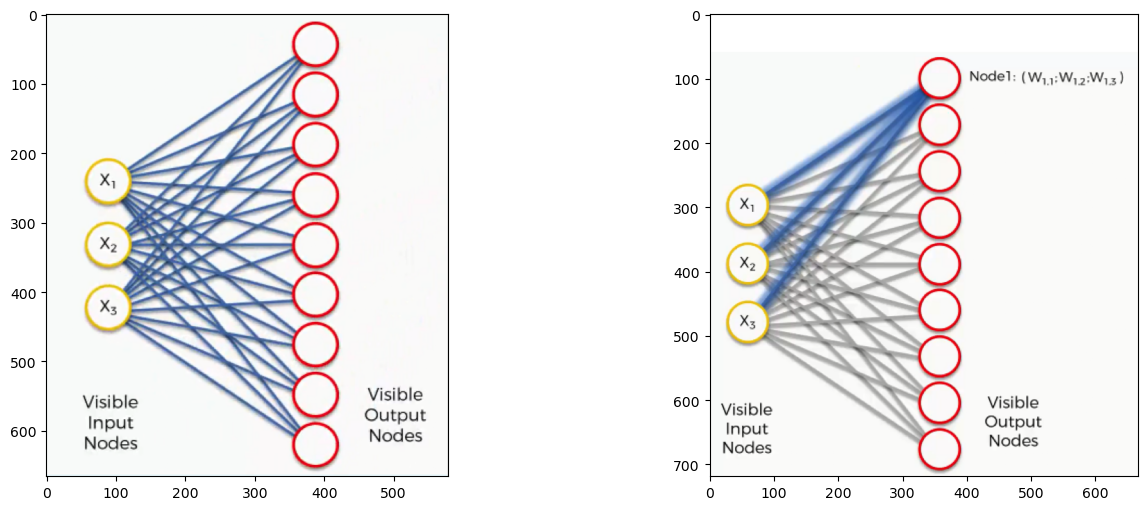

In [14]:
# credit @
# https://www.superdatascience.com/blogs/self-organizing-maps-soms-how-do-self-organizing-maps-learn-part-1/
img1 = plt.imread('jupyter_example/som_structure.png')
img2 = plt.imread('jupyter_example/som_structure2.png')

f, ax = plt.subplots(1, 2, figsize=(16,6))
ax[0].imshow(img1)
ax[1].imshow(img2)

In the above pictures, we're considering one data point **x** (with components x1, x2, x3) from a dataset with 3 features.
There's a "pipeline" going from the input layer to the output layer and neurons can influence each other, but that's the last similarly with supervised neural networks. Everything else is pretty different.

        There are no hidden layers, activation functions, or bias terms; only 3 things:
        Input data, Node indices, and Node weights

The neurons / "nodes", can influence each other like in supervised neural nets, but only *nearby* nodes. This close-ness is best described using a picture, so reshape the last layer structure of the above image into a grid:

<img src="jupyter_example/som_structure3.png" width="500" align="center">

*[Image credit: Zhang, Jintun & Meng, Dongping & Xi, Yuexiang. (2009). Ordination of self-organizing feature map neural networks and its application to the study of plant communities. Frontiers of Forestry in China. 4. 291-296. 10.1007/s11461-009-0041-3.]*

We'll be operating in two spaces with a bridge between them:

1. Input space (A x P, where P is the dimensionality of your input data)
2. node-space (2D, with NX x NY nodes)
3. The bridge - a matrix transform: 3d array with dims [ NX, NY, P ]. This can be interpreted as each node having a weight vector of size P.

Contains a good pic to screenshot! page 6
https://www.cs.bham.ac.uk/~jxb/INC/l16.pdf

### Best-Matching Unit and Neighborhoods ###

We will draw a sample data point from our input and use a metric to compute the distance between it and the weight vector of every node. The node that has the smallest distance is called the Best-Matching Unit (BMU). A variety of metrics get used, but the more common ones are the Euclidean, Manhattan, and Cosine Similarity. The most common, Euclidean, is simply

$$d(\textbf{a},\textbf{b}) = magnitude(\textbf{a}-\textbf{b}) = \sqrt{ \sum_{i=1}^P{ (a_i - b_i)^2} } $$

To represent proximity in "node-space", we'll need to specify a neighborhood function. This function will accept input in node-space and node-distances will be computed using the same metric as before. Common ones include a standard gaussian or a Ricker / Mexican Hat function.

<img src="jupyter_example/som_neighborhood2.png" width="750" align="center">


How wide these functions are decreases with iteration, as seen below:

<img src="jupyter_example/som_neighborhood.png" width="500" align="center">

*[Image credit: https://www.javatpoint.com/keras-kohonen-self-organizing-maps]*

How fast these sizes decrease is modelled using a pre-specified function, referred to as the *decay function*. Popular ones are linear and exponential decay wherein you specify what values you want to start and stop with and the number of iterations.

Text(0.5, 1.0, 'Decay Value')

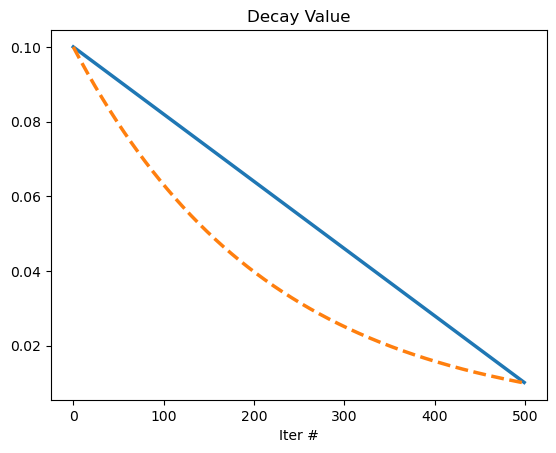

In [15]:
from newb_som import Decay

max_iter = 500
start_value = 0.1
end_value = 0.01

decay_dict = { 'linear' : [],
               'exp' : [] }
for i in range(max_iter):
    decay_dict['linear'].append( Decay._get_linear_decay(start_value, end_value, i, max_iter) )
    decay_dict['exp'].append( Decay._get_exponential_decay(start_value, end_value, i, max_iter) )

plt.plot( np.arange(max_iter), decay_dict['linear'], lw=2.5, linestyle='solid' )
plt.plot( np.arange(max_iter), decay_dict['exp'], lw=2.5, linestyle='dashed' )
plt.xlabel('Iter #')
plt.title('Decay Value')

### How does it learn? ###

Once we've determined which node is the BMU for a data point **x** and computed the neighborhood values all nodes (the neighborhood function is defined so that the neighborhood value at the BMU node is 1), we will update the weights. The learning equation is very similar to the standard one for a neural network, i.e. *new_weight = old_weight + learning_rate x (measure of correctness)*

However, there are two nuances:

1. The learning rate decreases with iteration. It will follow the same decay function as given for sigma, but you can specify different starting and ending values. A common starting and ending learning rate is 0.1 and 0.01.

2. The *measure of correctness* is a product of two variables: the neighborhood value for the considered node and the distance between the node's weight vector and **x**.

Expressing the equation more explicitly:

$$ \Delta(\textbf{weight}_{iq}) = \alpha_{t} * H_t(i,q;\sigma_t) * d( \textbf{weight}_{iq}, \textbf{x} ) $$

where ...
1. $\alpha_t$ is the learning rate at iteration t,
2. $H_t(i,q;\sigma_t)$ is the neighborhood function evaluated at node (i,q) where (i,q) is in the cartesian product [1, 2, ..., NX] x [1, 2, ..., NY] and $\sigma_t$ is the "width" of the neighborhood at iteration t (for a Gaussian, this is just the standard deviation).
3. $\textbf{weight}_{iq}$ is the weight vector for node (i,q)

Note that the learning stops when the max iteration is reached! **There is no tolerance criterion for terminating early since $\alpha_t$ and $\sigma_t$ depend on the iteration number!**

Since the weight vectors are trying to match themselves to the data, we can view the weight vector as the position in input-space and the node-index as the position in node-space. So for a simple 2D problem, we can watch over the iterations as the weight vectors converge to the distribution of the data!

Here's an example gif from the Wikipedia page for "Self-organizing map"

<img src="jupyter_example/TrainSOM.gif" width="300" align="center">

See how the nodes closest to the clusters move first and drag their neighbours with them. Farther away nodes only move slightly, while those in the upper right don't move at all!

## SOM: Visualization ##



Where SOMs really shine is their capacity to be visualized on a grid. The above gif is cute, but you can't recreate that when training an SOM on a 30-dim dataset. There are *tons* of different ways to visualize the node grid (see http://www.ifs.tuwien.ac.at/dm/somtoolbox/visualisations.html), but the two most popular ones are the hit-map and the U-matrix.

### Hit-map ###

To-do

### U-matrix ###

Since the SOM is an ordered grid (e.g. node (3,3) is **always** to the left of node (4,3) in node-space), we can study the changes in distances across the structure.

For each node, take the average of the weight-vector distances from it to its adjacent nodes (adjacent in the square grid sense, e.g. node (3,3) is adjacent to nodes (4,3), (3,4), (3,2), and (2,3)). Then use this in a colormap to see which nodes are very close to each other and which are far away.

Here's an example where people used a hexagonal structure instead of a square. The heatmap shows a large cluster in the bottom left, with occasional sparse points in the bottom right, and spread-out data in the top.

<img src="jupyter_example/umat.jpg" width="500" align="center">

*[Image credit: Bieroza, Magdalena & Baker, Andy & Bridgeman, John. (2012). Exploratory analysis of excitation-emission matrix fluorescence spectra with self-organizing maps-A tutorial. Education for Chemical Engineers. 7. 10.1016/j.ece.2011.10.002.]*

## SOM: Weight Initialization - Principal Component Analysis ##

Two common ways of initializing the weights is to either randomize them or linearly space them across the input-space. Given suitable SOM shape (the number of nodes along x and y), iteration number, decay function, learning rate, and so on, this can sometimes work just fine.

Here's an example of convergence:

In [16]:
def shuffle_data(dat, src):
    inds = np.random.permutation( dat.shape[0] )
    return dat[inds], src[inds]

<IPython.core.display.Javascript object>


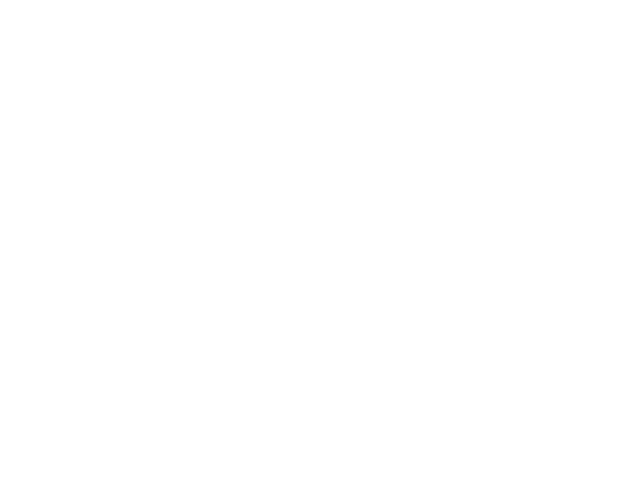

100%|██████████| 1200/1200 [00:45<00:00, 26.62it/s]


In [17]:
from newb_som import newb_som

#using this magic function allowes interactive plots to be rendered in the notebook;
# this line is needed for code blocks using matplotlib animations
%matplotlib notebook


"""
rules of thumb regarding SOM shape:

num nodes = 5 * sqrt(num data points)
square grid means nodes_x**2 = num_nodes, so
===> nodes_x = sqrt( 5 * sqrt(1500) ) ~= 14 

sigma_start = min(nodes_x,nodes_y) / 2
"""


# Initialize the SOM object
som = newb_som(som_shape=(14,14),
               sigma_start = 7, #4
               sigma_end = 0.1,
               learning_rate_start = 0.1,
               learning_rate_end = 0.01,
               decay = 'exponential',
               max_iter=1200,
               seed=rng_seed)


# lets shuffle the model data
g_dat, g_src = shuffle_data(g_dat, g_src)


# Train the SOM
cam = som.train(g_dat,
                plot_every=10,
                weight_init = 'linspace',
                show_neighborhood = False,
                animate=True)

# interval -> # of milliseconds between frames in an animation
cam.animate(interval=0.2)

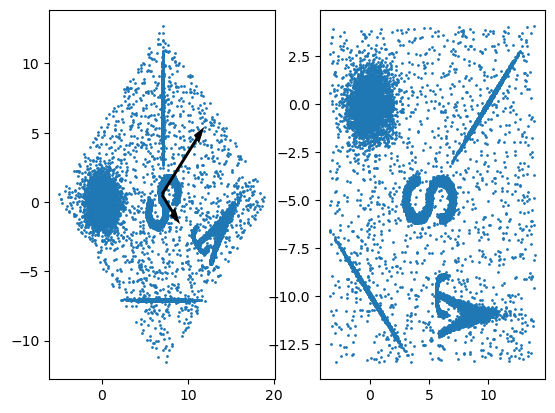

(array([17.98360743, 11.0970679 ]),
 array([[ 0.71076751,  0.703427  ],
        [-0.703427  ,  0.71076751]]),
 array([[ 6.76025722, -4.28983402],
        [10.39829889,  0.44926252],
        [-0.19372257, -1.01514833],
        ...,
        [-0.46628706, -9.4998566 ],
        [ 5.83679289, -9.21314356],
        [ 3.03453673, -5.31903943]]))

In [18]:
%matplotlib inline
from newb_som_driver import make_ugly_dataset, plot_pca

dat, src = make_ugly_dataset(pts_per_dat=10*1000)
plot_pca(dat)

In [19]:
#%matplotlib notebook
from newb_som import newb_som

from sklearn.datasets import make_circles

dat, src = make_circles(n_samples=1_000, factor=0.3, noise=0.05, random_state=rng_seed)

som = newb_som(som_shape=(15,15),
               sigma_start = 2,
               sigma_end = 0.1,
               learning_rate_start = 0.1,
               learning_rate_end = 0.01,
               decay = 'exponential',
               max_iter=1000,
               seed=rng_seed)


# Save an entire matplotlib figure is expensive, so if the training
# is slow, set plot_every to a large number or don't set it
cam = som.train(dat,
                 plot_every=15,
                 weight_init = 'linspace',
                 show_neighborhood = False,
                 animate=True)

cam.animate(interval=0.05)
#plt.show()

%matplotlib inline

100%|██████████| 1000/1000 [00:29<00:00, 34.25it/s]


## SOM: Final Notes ##

Additionally, note the organized structure of the grid! This topological structure is maintained as the SOM iterates (e.g. the node to the left of Node C above is **always** adjacent to Node C in 'node-space'. An unordered version of the model exists and is called a *neural gas* (https://en.wikipedia.org/wiki/Neural_gas)